In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# a

In [2]:
train_data = np.load("train.npz")
test_data  = np.load("test.npz")

x_train, y_train = train_data['a'], train_data['b']
x_test,  y_test  = test_data['a'],  test_data['b']

In [5]:
x_train_flat = []

for x_train_item in x_train:
    x_train_flat.append(x_train_item.ravel())
    

x_train_flat = np.array(x_train_flat)

In [6]:
def pca(x_train_flat):
    x = x_train_flat
    x_mean = x.mean(axis=0)
    x_normal = x - x_mean
    x_cov = np.cov(x_normal.T)
    w, v = np.linalg.eig(x_cov)

    idx = w.argsort()[::-1]   
    w = w[idx]
    v = v[:,idx]
    
    return v

In [7]:
v = pca(x_train_flat)

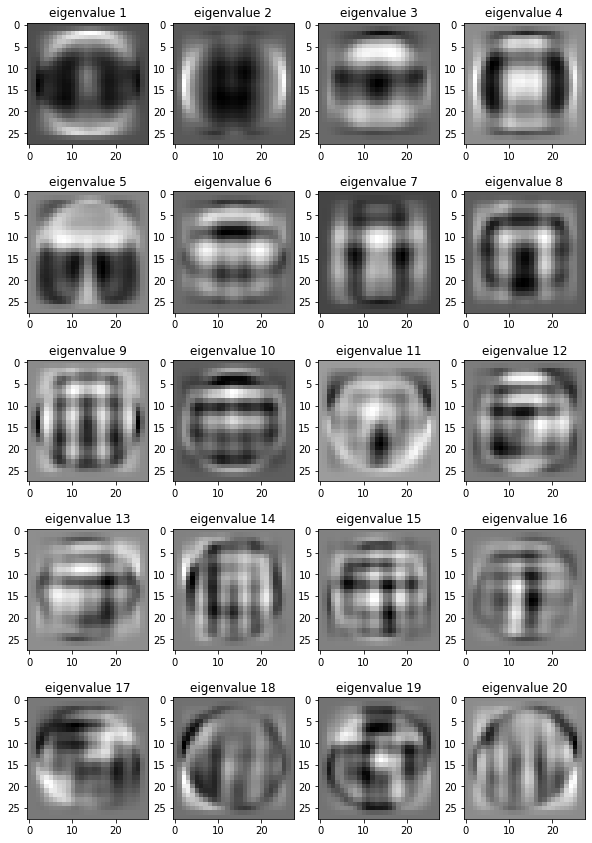

In [8]:
# plot top eigenvalues
fig, ax = plt.subplots(5,4)
for i in range(20):
    ax[int(i/4)][i%4].imshow(v[:,i].reshape(28,28), cmap="gray")
    ax[int(i/4)][i%4].set_title(f"eigenvalue {i+1}")

fig.set_size_inches(10,15)
plt.show()

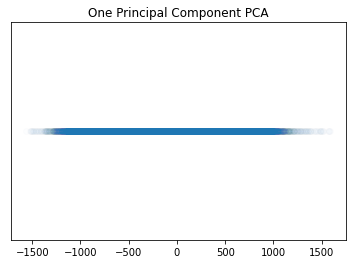

In [38]:
x_mean = x_train_flat.mean(axis=0)
x_trans = (x_train_flat-x_mean) @ np.linalg.pinv(v[:,:1]).T

plt.scatter(x_trans,[1]*len(x_trans),alpha=0.01)
plt.gca().get_yaxis().set_visible(False)

plt.title("One Principal Component PCA")
plt.show()

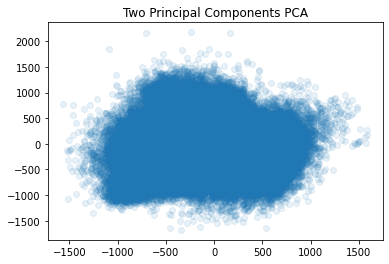

In [33]:
x_mean = x_train_flat.mean(axis=0)
x_trans = (x_train_flat-x_mean) @ np.linalg.pinv(v[:,:2]).T

plt.scatter(x_trans[:,0], x_trans[:,1], alpha=0.1)
plt.title("Two Principal Components PCA")
plt.show()

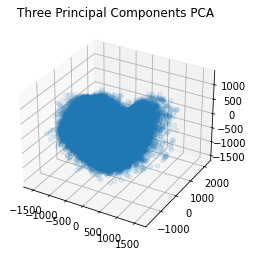

In [37]:
x_mean = x_train_flat.mean(axis=0)
x_trans = (x_train_flat-x_mean) @ np.linalg.pinv(v[:,:3]).T

ax = plt.axes(projection='3d')
ax.scatter3D(x_trans[:,0], x_trans[:,1], x_trans[:,2], alpha=0.1)
plt.title("Three Principal Components PCA")
plt.show()

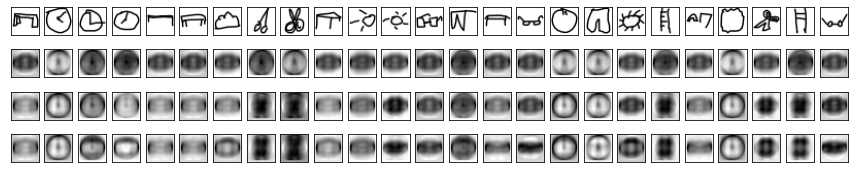

In [33]:
fig, ax = plt.subplots(4,25)
for i in range(25):
    ax[0][i].imshow(x_train[i], cmap="gray")
    ax[0][i].get_xaxis().set_visible(False)
    ax[0][i].get_yaxis().set_visible(False)
    
    for j in range(1,4):
        data_sample_reduced =  (x_train[i].ravel()-x_mean) @ np.linalg.pinv(v[:,:j]).T

        data_sample_reconstructed = data_sample_reduced @ v[:, :j].T + x_mean

        ax[j][i].imshow(data_sample_reconstructed.real.reshape(28,28), cmap="gray")
        ax[j][i].get_xaxis().set_visible(False)
        ax[j][i].get_yaxis().set_visible(False)
    
fig.set_size_inches(15,3)
plt.show()

# b

In [80]:
x = x_train_flat

In [81]:
x_maen = x.mean(axis=0)

In [82]:
x_class = []

for i in range(10):
    x_class.append([])

for i in range(len(y_train)):
    x_class[y_train[i]].append(x_train_flat[i])
    
for i in range(10):
    x_class[i] = np.array(x_class[i])

In [83]:
x_class_mean = []
for i in range(10):
    x_class_mean.append(x_class[i].mean(axis=0))

In [84]:
s_w = np.zeros((len(x_mean), len(x_mean)))
for i in range(len(y_train)):
    s_w += (x[i]-x_class_mean[y_train[i]]) @ (x[i]-x_class_mean[y_train[i]]).T

In [85]:
s_b = np.zeros((len(x_mean), len(x_mean)))
for i in range(10):
    s_b += (x_mean-x_class_mean[i]) @ (x_mean-x_class_mean[i]).T

In [86]:
s_w_inv = np.linalg.pinv(s_w)

In [87]:
w, v = np.linalg.eig(s_w_inv*s_b)

idx = w.argsort()[::-1]   
w = w[idx]
v = v[:,idx]

In [88]:
x_trans = (np.vstack((v[0].real, v[1].real)) @ x.T)

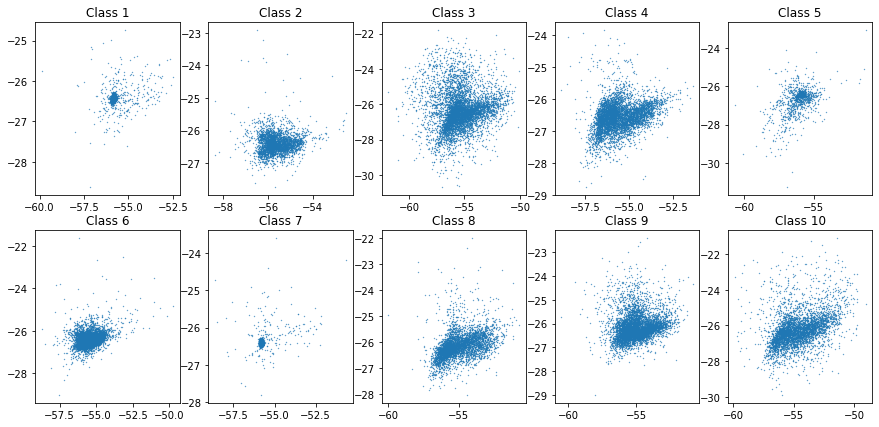

In [89]:
fig, ax = plt.subplots(2,5)
for i in range(10):
    inx = []
    for j in range(len(y_train)):
        if y_train[j]==i:
            inx.append(j)
    
    ax[int(i/5)][i%5].scatter(x_trans[::,inx][0], x_trans[::,inx][1], s=0.1, alpha=1)
    ax[int(i/5)][i%5].set_title(f"Class {i+1}")
    
fig.set_size_inches(15,7)
plt.show()

# c

In [48]:
import math

def find_cluster(X, k, mu):
    for i, x in X.iterrows():
        best_distance = math.inf
        best_cluster = None
        for j in range(k):
            new_distance = np.linalg.norm(x-mu.iloc[j])
            if new_distance < best_distance:
                best_distance = new_distance
                best_cluster = j
            
        X.at[i, "cluster"] = best_cluster
            
    return X

In [49]:
def calculate_means(X, k):
    data_list = []
    for i in range(k):
        data_list.append(X[X["cluster"]==i].mean())
    
    mu = pd.DataFrame(data_list)
    return mu

In [50]:
def sse_error(X, k):
    error = 0
    for i in range(k):
        X_cluster = X[X["cluster"]==i]
        m = X_cluster.mean()
        for index, x in X_cluster.iterrows():
            error += np.linalg.norm(x-m)**2
    return error

In [55]:
import math

def kmeanscluster(X, k, mu, tol, maxIter):
    prev_error = math.inf
    for iter in range(maxIter):
        print(iter)
        X = find_cluster(X, k, mu)
        mu = calculate_means(X, k)
        new_error = sse_error(X, k)
        if prev_error - new_error < tol:
            break
        prev_error = new_error
    return X

In [56]:
v = pca(x_train_flat)

x_mean = x_train_flat.mean(axis=0)
x_trans = (x_train_flat-x_mean) @ np.linalg.pinv(v[:,:2]).T

3
0
1
2
3
4
5
6
7
8
9
7
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9


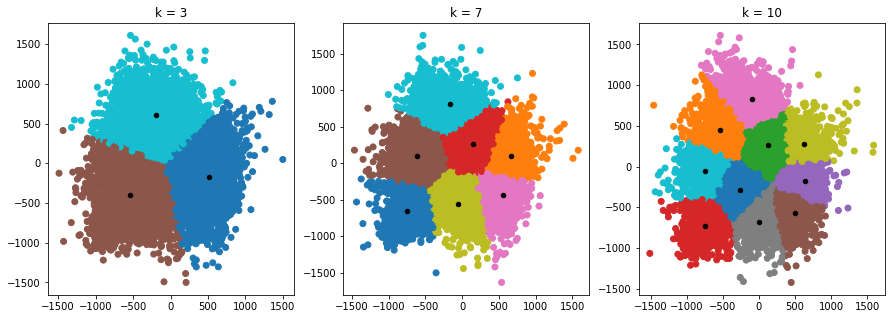

In [68]:
import matplotlib

fig, ax = plt.subplots(1,3) 
for i, k in enumerate([3, 7, 10]):
    print(k)
    X = pd.DataFrame(x_trans).sample(frac=0.1)
    
    mu = X.sample(n=k)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    C = kmeanscluster(X=X, k=k, mu=mu, tol=100, maxIter=10)

    ax[i].scatter(C[0],C[1], c=C["cluster"], cmap=matplotlib.colors.ListedColormap(colors))
    ax[i].set_title(f"k = {k}")
    
    means_0 = []
    means_1 = []
    for j in range(k):
        means_0.append(C[C["cluster"]==j][0].mean())
        means_1.append(C[C["cluster"]==j][1].mean())

    ax[i].scatter(means_0, means_1, c="black", s=20)
    
fig.set_size_inches(15,5)
plt.show()

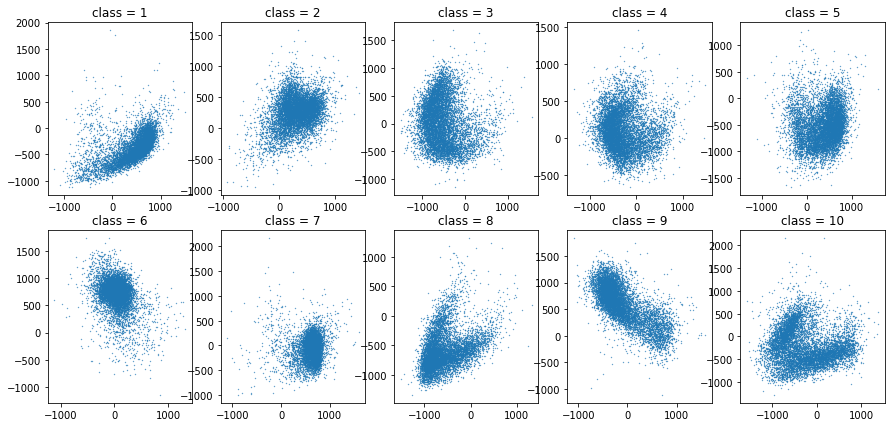

In [90]:
v = pca(x_train_flat)

x_mean = x_train_flat.mean(axis=0)
x_trans = (x_train_flat-x_mean) @ np.linalg.pinv(v[:,:2]).T

fig, ax = plt.subplots(2,5)

for i in range(10):
    x_class = []
    for j in range(len(y_train)):
        if y_train[j]==i:
            x_class.append(x_trans[j])
        
    x_class = np.array(x_class)
    ax[int(i/5)][i%5].scatter(x_class[:, 0], x_class[:,1], s=0.1, alpha=1)
    ax[int(i/5)][i%5].set_title(f"class = {i+1}")
    
fig.set_size_inches(15,7)
plt.show()

# d

In [111]:
def center_class(x_trans, y_train, class_list):
    X = pd.DataFrame(x_trans)
    X["class"] = y_train
    X = X[X["class"].isin(class_list)]
    del X["class"]
    return X.mean()

3
0
1
2
3
4
5
6
7
8
9
7
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9


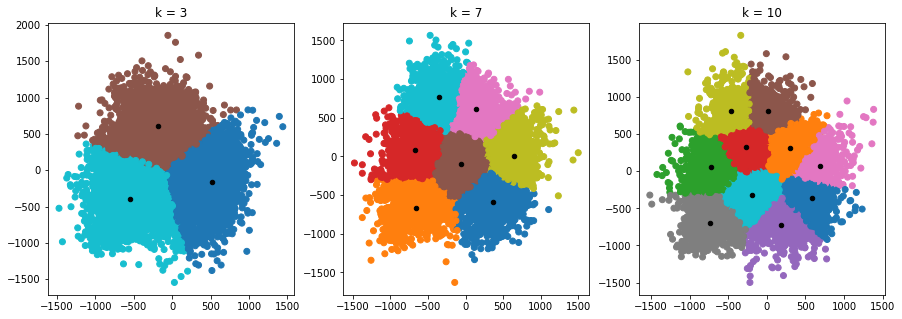

In [116]:
import matplotlib

fig, ax = plt.subplots(1,3) 
for i, k in enumerate([3, 7, 10]):
    print(k)
    X = pd.DataFrame(x_trans).sample(frac=0.1)
        
    if k==3:
        mu = pd.DataFrame([center_class(x_trans, y_train, [0,2,4,6])
                  ,center_class(x_trans, y_train, [1,3])
                  ,center_class(x_trans, y_train, [5,7,8,9])])
    elif k==7:
        mu = pd.DataFrame([center_class(x_trans, y_train, [0,1,4])
                           ,center_class(x_trans, y_train, [7,9])
                           ,center_class(x_trans, y_train, [2])
                           ,center_class(x_trans, y_train, [3])
                           ,center_class(x_trans, y_train, [5])
                           ,center_class(x_trans, y_train, [6])
                           ,center_class(x_trans, y_train, [8])])
    elif k==10:
        mu = pd.DataFrame([center_class(x_trans, y_train, [0])
                           ,center_class(x_trans, y_train, [1])
                           ,center_class(x_trans, y_train, [2])
                           ,center_class(x_trans, y_train, [3])
                           ,center_class(x_trans, y_train, [4])
                           ,center_class(x_trans, y_train, [5])
                           ,center_class(x_trans, y_train, [6])
                           ,center_class(x_trans, y_train, [7])
                           ,center_class(x_trans, y_train, [8])
                           ,center_class(x_trans, y_train, [9])])
        
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    C = kmeanscluster(X=X, k=k, mu=mu, tol=100, maxIter=10)

    ax[i].scatter(C[0],C[1], c=C["cluster"], cmap=matplotlib.colors.ListedColormap(colors))
    ax[i].set_title(f"k = {k}")
    
    means_0 = []
    means_1 = []
    for j in range(k):
        means_0.append(C[C["cluster"]==j][0].mean())
        means_1.append(C[C["cluster"]==j][1].mean())

    ax[i].scatter(means_0, means_1, c="black", s=20)
    
fig.set_size_inches(15,5)
plt.show()

In [117]:
# e